In [6]:
import boto3
import pandas as pd
import numpy as np
import io
import sys
import os
import time
import seaborn as sns
# local libraries
sys.path.append(os.path.abspath(os.path.join(sys.path[0], '..', 'src', 'lib')))
import athena_connect
import market_maker_training

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.mode.chained_assignment = None
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

In [3]:
import datetime
from datetime import timedelta

(datetime.datetime.utcnow() - timedelta(days=10)).strftime("%Y-%m-%d")
#datetime.datetime.utcnow().strftime("%Y-%m-%d")

'2018-06-26'

# "Market Maker" Model Development

In [2]:
def features(feature_minutes_list, trade_window_list=[10]):
    #TODO: move this config to simulation argument 
    coin_pair_dict = {'ethusdt':'target',
                  'btcusdt':'alt',
                  'trxeth':'through'}
    print(f"Coin feature configuration: {coin_pair_dict}")

    mm_training = market_maker_training.MarketMakerTraining(coin_pair_dict, feature_minutes_list, trade_window_list)
    try:
        mm_training.set_training_data()
    except Exception as e:
        print(f"Failed setting training data: {e}")
        return
    return mm_training.training_df, mm_training.feature_column_list, mm_training.target_column_list

feature_minutes_list = [1,3,5,10,20,30,40,50,60,120,240,480,960]
features_df, feature_col, target_col_list = features(feature_minutes_list)
features_df.head(20)

Coin feature configuration: {'ethusdt': 'target', 'btcusdt': 'alt', 'trxeth': 'through'}


KeyboardInterrupt: 

In [37]:
features_df.head(11)['ethusdt_open'].mean()

729.5418181818181

In [19]:
feature_col

['trade_day_of_week',
 'trade_hour',
 'ethusdt_open',
 'ethusdt_high',
 'ethusdt_low',
 'ethusdt_close',
 'ethusdt_volume',
 'ethusdt_quote_asset_volume',
 'ethusdt_trade_count',
 'ethusdt_tbbav',
 'ethusdt_tbqav',
 'prev_1_ethusdt_open_perc_chg',
 'prev_1_ethusdt_open_rate_chg',
 'prev_1_ethusdt_high_perc_chg',
 'prev_1_ethusdt_low_perc_chg',
 'prev_1_ethusdt_volume_perc_chg',
 'prev_1_ethusdt_qav_perc_chg',
 'prev_1_ethusdt_trade_count_perc_chg',
 'prev_1_ethusdt_tbbav_perc_chg',
 'prev_1_ethusdt_tbqav_perc_chg',
 'prev_3_ethusdt_open_perc_chg',
 'prev_3_ethusdt_open_rate_chg',
 'prev_3_ethusdt_high_perc_chg',
 'prev_3_ethusdt_low_perc_chg',
 'prev_3_ethusdt_volume_perc_chg',
 'prev_3_ethusdt_qav_perc_chg',
 'prev_3_ethusdt_trade_count_perc_chg',
 'prev_3_ethusdt_tbbav_perc_chg',
 'prev_3_ethusdt_tbqav_perc_chg',
 'prev_5_ethusdt_open_perc_chg',
 'prev_5_ethusdt_open_rate_chg',
 'prev_5_ethusdt_high_perc_chg',
 'prev_5_ethusdt_low_perc_chg',
 'prev_5_ethusdt_volume_perc_chg',
 'prev_

### Feature Correlations

In [5]:
#features_df[['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
#                    'prev_min_perc_chg','prev_5_min_perc_chg','prev_10_min_perc_chg',
#                    'alt_prev_min_perc_chg','alt_prev_5_min_perc_chg']].corr()

,avg_5_min_price,avg_5_min_qty,avg_5_min_trade_count,avg_qty,trade_count,avg_price,prev_min_perc_chg,prev_5_min_perc_chg,prev_10_min_perc_chg,alt_prev_min_perc_chg,alt_prev_5_min_perc_chg
avg_5_min_price,1.000000,-0.464462,0.443390,-0.360719,0.415828,0.999865,-0.002920,0.004569,0.015400,0.005399,0.010705
avg_5_min_qty,-0.464462,1.000000,-0.213083,0.770215,-0.197288,-0.464449,-0.001294,-0.005825,-0.012386,-0.001342,-0.002891
avg_5_min_trade_count,0.443390,-0.213083,1.000000,-0.165169,0.927295,0.443467,0.005967,0.030908,0.069723,0.005983,0.011221
avg_qty,-0.360719,0.770215,-0.165169,1.000000,-0.175320,-0.360742,-0.000312,-0.008108,-0.011755,0.002815,-0.003334
trade_count,0.415828,-0.197288,0.927295,-0.175320,1.000000,0.415875,-0.027027,0.051618,0.079765,0.004120,0.010881
avg_price,0.999865,-0.464449,0.443467,-0.360742,0.415875,1.000000,0.007038,0.017925,0.024238,0.005887,0.011418
prev_min_perc_chg,-0.002920,-0.001294,0.005967,-0.000312,-0.027027,0.007038,1.000000,0.441221,0.297219,0.088278,0.049221
prev_5_min_perc_chg,0.004569,-0.005825,0.030908,-0.008108,0.051618,0.017925,0.441221,1.000000,0.682563,0.041963,0.102851
prev_10_min_perc_chg,0.015400,-0.012386,0.069723,-0.011755,0.079765,0.024238,0.297219,0.682563,1.000000,0.033367,0.084629
alt_prev_min_perc_chg,0.005399,-0.001342,0.005983,0.002815,0.004120,0.005887,0.088278,0.041963,0.033367,1.000000,0.471056


## Feature Tools: Deep feature synthesis

In [58]:
import featuretools as ft

# Create entity set
es = ft.EntitySet(id='trades')
es = es.entity_from_dataframe(entity_id="trades",
                              dataframe=features_df[feature_col],
                              make_index = True,
                              index="trade_id",
                              time_index="trade_datetime")
                              #variable_types={"trade_day_of_week": ft.variable_types.Categorical,"trade_hour": ft.variable_types.Categorical})

In [61]:
es

Entityset: trades
  Entities:
    trades [Rows: 218141, Columns: 91]
  Relationships:
    No relationships

In [64]:
# Deep feature synthesis
features, feature_names = ft.dfs(entityset=es, target_entity='trades', max_depth=3)
features.head()

,trade_day_of_week,trade_hour,open,high,low,close,volume,quote_asset_volume,trade_count,tbbav,tbqav,ethbtc_open,ethbtc_high,ethbtc_low,ethbtc_close,ethbtc_volume,ethbtc_quote_asset_volume,ethbtc_trade_count,ethbtc_tbbav,ethbtc_tbqav,ethusdt_open,ethusdt_high,ethusdt_low,close.1,ethusdt_volume,ethusdt_quote_asset_volume,ethusdt_trade_count,ethusdt_tbbav,ethusdt_tbqav,prev_1_open_perc_chg,prev_2_3_open_perc_chg,prev_3_4_open_perc_chg,prev_4_5_open_perc_chg,prev_5_open_perc_chg,prev_10_open_perc_chg,prev_5_open_rate_chg,prev_10_open_rate_chg,prev_5_high_perc_chg,prev_10_high_perc_chg,prev_5_low_perc_chg,prev_10_low_perc_chg,prev_5_volume_perc_chg,prev_10_volume_perc_chg,prev_5_qav_perc_chg,prev_10_qav_perc_chg,prev_5_trade_count_perc_chg,prev_10_trade_count_perc_chg,prev_5_tbbav_perc_chg,prev_10_tbbav_perc_chg,prev_5_tbqav_perc_chg,prev_10_tbqav_perc_chg,prev_1_open_perc_chg.1,prev_5_ethbtc_open_perc_chg,prev_10_ethbtc_open_perc_chg,prev_5_ethbtc_open_rate_chg,prev_10_open_rate_chg.1,prev_5_ethbtc_high_perc_chg,prev_10_high_perc_chg.1,prev_5_ethbtc_low_perc_chg,prev_10_ethbtc_low_perc_chg,prev_5_ethbtc_volume_perc_chg,prev_10_ethbtc_volume_perc_chg,prev_5_ethbtc_qav_perc_chg,prev_10_ethbtc_qav_perc_chg,prev_5_ethbtc_trade_count_perc_chg,prev_10_ethbtc_trade_count_perc_chg,prev_5_ethbtc_tbbav_perc_chg,prev_10_ethbtc_tbbav_perc_chg,prev_5_ethbtc_tbqav_perc_chg,prev_10_ethbtc_tbqav_perc_chg,prev_1_open_perc_chg.2,prev_5_ethusdt_open_perc_chg,prev_10_ethusdt_open_perc_chg,prev_5_ethusdt_open_rate_chg,prev_10_ethusdt_open_rate_chg,prev_5_ethusdt_high_perc_chg,prev_10_ethusdt_high_perc_chg,prev_5_ethusdt_low_perc_chg,prev_10_ethusdt_low_perc_chg,prev_5_ethusdt_volume_perc_chg,prev_10_ethusdt_volume_perc_chg,prev_5_ethusdt_qav_perc_chg,prev_10_ethusdt_qav_perc_chg,prev_5_ethusdt_trade_count_perc_chg,prev_10_ethusdt_trade_count_perc_chg,prev_5_ethusdt_tbbav_perc_chg,prev_10_ethusdt_tbbav_perc_chg,prev_5_ethusdt_tbqav_perc_chg,prev_10_ethusdt_tbqav_perc_chg,DAY(trade_datetime),YEAR(trade_datetime),MONTH(trade_datetime),WEEKDAY(trade_datetime)
trade_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0,0.000059,0.000059,0.000059,0.000059,891404.0,52.918951,48,821249.0,48.753948,0.053586,0.053613,0.053496,0.053520,162.312,8.691875,276,102.213,5.475718,733.01,733.97,732.75,0.000059,19.77247,14490.961596,29,1.74674,1281.803635,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,1,2018,1,0
1,1,0,0.000059,0.000059,0.000059,0.000059,914132.0,54.276705,61,763155.0,45.313666,0.053522,0.053599,0.053522,0.053580,194.671,10.425546,171,36.347,1.947037,733.34,734.52,732.51,0.000059,26.05199,19105.098094,50,21.31950,15638.007363,0.067397,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,-0.119434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,5.560236e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,1,2018,1,0
2,1,0,0.000059,0.000059,0.000059,0.000059,1484245.0,88.021694,88,667734.0,39.620120,0.053580,0.053580,0.053474,0.053579,228.432,12.231527,324,89.497,4.793154,732.51,734.49,732.49,0.000059,15.71883,11515.440038,40,3.12611,2291.043904,-0.033676,0.067397,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.108367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,-1.397542e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,1,2018,1,0
3,1,0,0.000059,0.000059,0.000059,0.000059,2265403.0,133.662586,153,839866.0,49.549253,0.053579,0.053598,0.053519,0.053529,249.478,13.359549,277,125.317,6.713129,732.51,733.83,730.00,0.000059,29.43683,21532.608268,59,3.50540,2567.132006,-0.235809,-0.033676,0.033698,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [65]:
feature_names

[<Feature: trade_day_of_week>,
 <Feature: trade_hour>,
 <Feature: open>,
 <Feature: high>,
 <Feature: low>,
 <Feature: close>,
 <Feature: volume>,
 <Feature: quote_asset_volume>,
 <Feature: trade_count>,
 <Feature: tbbav>,
 <Feature: tbqav>,
 <Feature: ethbtc_open>,
 <Feature: ethbtc_high>,
 <Feature: ethbtc_low>,
 <Feature: ethbtc_close>,
 <Feature: ethbtc_volume>,
 <Feature: ethbtc_quote_asset_volume>,
 <Feature: ethbtc_trade_count>,
 <Feature: ethbtc_tbbav>,
 <Feature: ethbtc_tbqav>,
 <Feature: ethusdt_open>,
 <Feature: ethusdt_high>,
 <Feature: ethusdt_low>,
 <Feature: close.1>,
 <Feature: ethusdt_volume>,
 <Feature: ethusdt_quote_asset_volume>,
 <Feature: ethusdt_trade_count>,
 <Feature: ethusdt_tbbav>,
 <Feature: ethusdt_tbqav>,
 <Feature: prev_1_open_perc_chg>,
 <Feature: prev_2_3_open_perc_chg>,
 <Feature: prev_3_4_open_perc_chg>,
 <Feature: prev_4_5_open_perc_chg>,
 <Feature: prev_5_open_perc_chg>,
 <Feature: prev_10_open_perc_chg>,
 <Feature: prev_5_open_rate_chg>,
 <Feature:

### Feature Selection

In [ ]:
from sklearn import ensemble
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, classification_report, neg_mean_squared_error
from sklearn.model_selection import train_test_split

import xgboost as xgb

In [ ]:
target_col = target_col_list[0]

features_df = features_df[:-10]
# Split for last x days training and adjust for look ahead 
X_train, y_train = features_df[960:-1450][feature_col], features_df[960:-1450][target_col]  # less training data 
X_test, y_test = features_df[-1440:][feature_col], features_df[-1440:][target_col]


In [ ]:
if max(X_train.index) > min(X_test.index) + 10:
    raise Exception("The training set includes test data!")

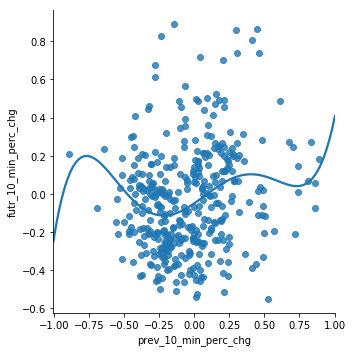

In [8]:
#sns.lmplot('prev_10_min_perc_chg', 'futr_10_min_perc_chg', data = features_df[-400:-20], fit_reg=True, order=5, ci=None)

In [9]:
features_df

,coin_partition,trade_date,trade_minute,trade_count,avg_price,avg_qty,avg_5_min_price,avg_5_min_qty,avg_5_min_trade_count,prev_min_perc_chg,...,prev_10_min_perc_chg,prev_5_min_rate_chg,prev_10_min_rate_chg,alt_prev_min_perc_chg,alt_prev_5_min_perc_chg,alt_prev_5_min_rate_chg,alt_prev_10_min_rate_chg,futr_min_perc_chg,futr_5_min_perc_chg,futr_10_min_perc_chg
0,trxeth,2018-01-01,25246080,47,0.000059,18966.042553,0.000059,18966.042553,47.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014776,-0.378247,-0.017643
1,trxeth,2018-01-01,25246081,48,0.000059,19044.416667,0.000059,19005.229610,47.500000,0.014776,...,0.000000,0.000000,0.000000,-0.037657,0.000000,0.000000,0.000000,-0.136973,-0.591329,0.519351
2,trxeth,2018-01-01,25246082,69,0.000059,21510.797101,0.000059,19840.418774,54.666667,-0.136973,...,0.000000,0.000000,0.000000,-0.025373,0.000000,0.000000,0.000000,-0.696358,-0.389388,1.106515
3,trxeth,2018-01-01,25246083,104,0.000059,21782.721154,0.000059,20325.994369,67.000000,-0.696358,...,0.000000,0.000000,0.000000,-0.148897,0.000000,0.000000,0.000000,-0.369630,0.082627,1.960595
4,trxeth,2018-01-01,25246084,74,0.000059,21077.729730,0.000059,20476.341441,68.400000,-0.369630,...,0.000000,0.000000,0.000000,-0.202087,0.000000,0.000000,0.000000,0.815746,0.747503,2.428942
5,trxeth,2018-01-01,25246085,64,0.000059,8691.218750,0.000059,18512.154326,67.666667,0.815746,...,0.000000,1.193993,0.000000,-0.236021,-0.648528,0.412507,0.000000,-0.199147,0.361973,1.526628
6,trxeth,2018-01-01,25246086,44,0.000059,26513.795455,0.000059,19770.113143,67.166667,-0.199147,...,0.000000,0.392182,0.000000,-0.350524,-0.959484,0.608959,0.000000,0.065891,1.117286,1.669492
7,trxeth,2018-01-01,25246087,31,0.000059,12042.967742,0.000059,18603.204989,64.333333,0.065891,...,0.000000,0.455279,0.000000,-0.062785,-0.996546,0.933761,0.000000,-0.225798,1.501750,1.700682
8,trxeth,2018-01-01,25246088,52,0.000059,22206.673077,0.000059,18719.184318,61.500000,-0.225798,...,0.000000,-0.308425,0.000000,0.064042,-0.785415,0.849457,0.000000,0.292242,1.876418,1.954042
9,trxeth,2018-01-01,25246089,106,0.000059,15623.160377,0.000059,17692.590855,61.833333,0.292242,...,0.000000,-0.455261,0.000000,0.072559,-0.512373,0.584933,0.000000,0.429955,1.668963,1.816133


## Standardize features

In [77]:
# PCA is impacted by scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## PCA

In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components=25)
pca.fit(X_train)
print(sum(pca.explained_variance_ratio_)) 

0.8773786874088525


In [80]:
# Apply pca
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

## Model Selection

In [ ]:
def print_metrics(model, y_test, X_test):
    r2 = r2_score(y_test, model.predict(X_test))
    neg_mse = neg_mean_squared_error(y_test, model.predict(X_test))
    print(f"R2: {r2}, neg_mean_squared_error: {neg_mse}")

### Gradient Booster

In [15]:
clf = ensemble.GradientBoostingRegressor(n_estimators=500, learning_rate=.01, max_depth=6, 
                                                         max_features=.1, min_samples_leaf=1)

clf.fit(X_train, y_train)
print_metrics(clf, y_test, X_test)

R2: 0.041671531742411894


In [ ]:
clf = ensemble.GradientBoostingRegressor(n_estimators=500, learning_rate=.02, max_depth=4, 
                                                         max_features=1, min_samples_leaf=9)
clf.fit(X_train, y_train)
print_metrics(clf, y_test, X_test)

#### GB Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV 
param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01], 
              'max_depth': [4, 6],     
              'min_samples_leaf': [1, 3, 5, 9, 17], 
              'max_features': [1.0, 0.3, 0.1]} 
est = ensemble.GradientBoostingRegressor(n_estimators=2000) 
gs_cv = GridSearchCV(est, param_grid).fit(X_train, y_train) # best hyperparameter setting 
gs_cv.best_params_

### Random Forest

In [ ]:
rf = ensemble.RandomForestRegressor(n_estimators=50)

rf.fit(X_train, y_train)
print_metrics(rf, y_test, X_test)

In [33]:
rf.feature_importances_

array([0.1173184 , 0.09437128, 0.12177482, 0.01972312, 0.02507456,
       0.08169567, 0.0262471 , 0.06485572, 0.0413153 , 0.03547063,
       0.08431119, 0.08253181, 0.07452237, 0.06892009, 0.06186795])

### XGBoost

In [16]:
model = xgb.XGBRegressor()

model.fit(X_train, y_train)
print_metrics(model, y_test, X_test)

0.04157258620055293

In [ ]:
# Tuning
model = xgb.XGBRegressor(max_depth=5, n_estimators=100)

model.fit(X_train, y_train)
r2_score(y_test, model.predict(X_test))

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

train = X_train
valid = X_test
y_valid = y_test

def objective(space):
    clf = xgb.XGBRegressor(n_estimators = 100,
                            max_depth = space['max_depth'],
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'])

    eval_set  = [( train, y_train), ( valid, y_valid)]

    clf.fit(train[col_train], y_train,
            eval_set=eval_set, eval_metric="auc",
            early_stopping_rounds=30)

    pred = clf.predict_proba(valid)[:,1]
    #auc = roc_auc_score(y_valid, pred)
    r2 = r2_score(y_test, model.predict(X_test))
    print("SCORE:", r2)
    return{'loss':1-r2, 'status': STATUS_OK }


space ={
        'max_depth': hp.quniform("x_max_depth", 5, 30, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1)
    }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print(best)

In [30]:
model.feature_importances_

array([0.01119942, 0.00830925, 0.02565029, 0.00686416, 0.00830925,
       0.00180636, 0.00541908, 0.0025289 , 0.00541908, 0.00541908,
       0.00289017, 0.0025289 , 0.        , 0.00397399, 0.00650289,
       0.00180636, 0.        , 0.        , 0.00180636, 0.        ,
       0.00397399, 0.00216763, 0.00325145, 0.00325145, 0.00216763,
       0.00072254, 0.        , 0.00072254, 0.        , 0.00578035,
       0.00361272, 0.00397399, 0.0050578 , 0.00144509, 0.00072254,
       0.00036127, 0.00216763, 0.        , 0.00433526, 0.00325145,
       0.00289017, 0.00216763, 0.00216763, 0.        , 0.00036127,
       0.00144509, 0.        , 0.00289017, 0.00469653, 0.00469653,
       0.00650289, 0.0025289 , 0.00072254, 0.00036127, 0.00180636,
       0.00036127, 0.00541908, 0.00975434, 0.00939306, 0.00614162,
       0.00180636, 0.        , 0.00036127, 0.00072254, 0.00036127,
       0.00469653, 0.00578035, 0.00614162, 0.00686416, 0.00072254,
       0.        , 0.00108382, 0.00289017, 0.        , 0.00614

### Linear Regression

In [ ]:
lm = linear_model.LinearRegression()

lm.fit(X_train, y_train)
print_metrics(lm, y_test, X_test)

In [ ]:
clf = linear_model.RidgeCV(alphas=(.0001,.001,.01,.1,1,10), normalize=True)
#clf = linear_model.Ridge(alpha=10, normalize=True)
clf.fit(X_train, y_train)
print_metrics(clf, y_test, X_test)

In [14]:
import statsmodels.api as sm
X = sm.add_constant(X_train)
model = sm.OLS(y_train, X)
results = model.fit()

print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     futr_10_open_perc_chg   R-squared:                       0.111
Model:                               OLS   Adj. R-squared:                  0.110
Method:                    Least Squares   F-statistic:                     95.46
Date:                   Fri, 06 Jul 2018   Prob (F-statistic):               0.00
Time:                           11:02:01   Log-Likelihood:            -2.2782e+05
No. Observations:                 261119   AIC:                         4.563e+05
Df Residuals:                     260777   BIC:                         4.599e+05
Df Model:                            341                                         
Covariance Type:               nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

### Stochastic Gradient Descent Regression

In [ ]:
# log data??
#y = np.log1p(y_train)
#y_ = np.log1p(y_test)

# transform and scale data
scaler = StandardScaler()
scaler.fit(X_train)
X = scaler.transform(X_train)
X_ = scaler.transform(X_test)

# train
sdg = linear_model.SGDRegressor(penalty='l2', alpha=0.15, max_iter=2000)
#sdg = linear_model.SGDRegressor(penalty='elasticnet', loss='epsilon_insensitive', alpha=0.15, max_iter=2000)

sdg.fit(X, y_train)
print_metrics(sgd, y_test, X_)

In [36]:
# Grid search
from sklearn.model_selection import GridSearchCV 
param_grid = {'alpha': [0.2,0.15,0.1,0.01,0.001,0.0001,0.00001], 
              'max_iter': [50,200,600,1200,2000,6000,12000],     
              'loss': ['squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'], 
              'penalty': ['l2','l1','elasticnet']} 
est = linear_model.SGDRegressor() 
sgd_cv = GridSearchCV(est, param_grid).fit(X, y) # best hyperparameter setting 
sgd_cv.best_params_

NameError: name 'y' is not defined

### Support Vector Machine (RBF Kernel)

In [ ]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)

svr_rbf.fit(X_train, y_train)
print_metrics(svr_rbf, y_test, X_test)

### Polynomial Regression (with Ridge Regularization)

In [ ]:
%%time

poly = PolynomialFeatures(degree=3)
X = poly.fit_transform(X_train)
X_ = poly.fit_transform(X_test)
#clf = linear_model.LinearRegression(normalize=True)
clf = linear_model.RidgeCV(alphas=(.0001,.001,.01,.1,1,10), normalize=True)
#clf = linear_model.Ridge(alpha=10, normalize=True)
clf.fit(X, y_train)
print(r2_score(y_test, clf.predict(X_)))

# Validate Scoring Features

For this to work, you must adjust the scoring library to return more than 970 minuts worth of data

In [7]:
import market_maker_scoring

mm_scoring = market_maker_scoring.MarketMakerScoring()
# Set scoring data and retrieve the most recent minutes features
mm_scoring.set_scoring_data(in_parallel=True)
recent_df = mm_scoring.scoring_features_df.sort_values('open_time')
# Check time diff
latest_timestamp = recent_df.iloc[-1:]['close_time_x'].item() / 1000
print(f"Last timestamp in scoring data: {latest_timestamp} compared to current: {time.time()} with {time.time() - latest_timestamp}")

Last timestamp in scoring data: 1530928619.999 compared to current: 1530928607.7281559 with -12.270843029022217


In [8]:
recent_df

,open_time,ethusdt_open,ethusdt_high,ethusdt_low,ethusdt_close,ethusdt_volume,close_time_x,ethusdt_quote_asset_volume,ethusdt_trade_count,ethusdt_tbbav,ethusdt_tbqav,ethusdt_ignore,minute_x,trade_hour,trade_day_of_week,prev_1_ethusdt_open,prev_1_ethusdt_open_perc_chg,prev_1_ethusdt_open_rate_chg,prev_1_ethusdt_high,prev_1_ethusdt_high_perc_chg,prev_1_ethusdt_high_rate_chg,prev_1_ethusdt_low,prev_1_ethusdt_low_perc_chg,prev_1_ethusdt_low_rate_chg,prev_1_ethusdt_volume,prev_1_ethusdt_volume_perc_chg,prev_1_ethusdt_volume_rate_chg,prev_1_ethusdt_qav,prev_1_ethusdt_qav_perc_chg,prev_1_ethusdt_qav_rate_chg,prev_1_ethusdt_trade_count,prev_1_ethusdt_trade_count_perc_chg,prev_1_ethusdt_trade_count_rate_chg,prev_1_ethusdt_tbbav,prev_1_ethusdt_tbbav_perc_chg,prev_1_ethusdt_tbbav_rate_chg,prev_1_ethusdt_tbqav,prev_1_ethusdt_tbqav_perc_chg,prev_1_ethusdt_tbqav_rate_chg,prev_3_ethusdt_open,prev_3_ethusdt_open_perc_chg,prev_3_ethusdt_open_rate_chg,prev_3_ethusdt_high,prev_3_ethusdt_high_perc_chg,prev_3_ethusdt_high_rate_chg,prev_3_ethusdt_low,prev_3_ethusdt_low_perc_chg,prev_3_ethusdt_low_rate_chg,prev_3_ethusdt_volume,prev_3_ethusdt_volume_perc_chg,...,prev_480_trxeth_tbqav_rate_chg,prev_960_trxeth_open,prev_960_trxeth_open_perc_chg,prev_960_trxeth_open_rate_chg,prev_960_trxeth_high,prev_960_trxeth_high_perc_chg,prev_960_trxeth_high_rate_chg,prev_960_trxeth_low,prev_960_trxeth_low_perc_chg,prev_960_trxeth_low_rate_chg,prev_960_trxeth_volume,prev_960_trxeth_volume_perc_chg,prev_960_trxeth_volume_rate_chg,prev_960_trxeth_qav,prev_960_trxeth_qav_perc_chg,prev_960_trxeth_qav_rate_chg,prev_960_trxeth_trade_count,prev_960_trxeth_trade_count_perc_chg,prev_960_trxeth_trade_count_rate_chg,prev_960_trxeth_tbbav,prev_960_trxeth_tbbav_perc_chg,prev_960_trxeth_tbbav_rate_chg,prev_960_trxeth_tbqav,prev_960_trxeth_tbqav_perc_chg,prev_960_trxeth_tbqav_rate_chg,current_interaction,current_1_interaction,current_2_interaction,current_3_interaction,current_4_interaction,current_5_interaction,interaction_average,avg_5_btcusdt_open_interaction,current_6_interaction,current_7_interaction,current_8_interaction,current_9_interaction,current_10_interaction,avg_10_btcusdt_open_interaction,current_11_interaction,current_12_interaction,current_13_interaction,current_14_interaction,current_15_interaction,current_16_interaction,current_17_interaction,current_18_interaction,current_19_interaction,current_20_interaction,avg_20_btcusdt_open_interaction
0,1530870420000,458.21,458.41,457.57,457.92,199.83123,1530870479999,91530.315387,118,22.48549,10298.440835,0,25514507,9,5,0.00,0.000000,0.0,0.00,0.000000,0.0,0.00,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-13.189444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1530870480000,457.91,458.00,457.58,457.76,42.47282,1530870539999,19443.439289,85,28.52722,13061.507226,0,25514508,9,5,458.21,-0.065472,0.0,458.41,-0.089440,0.0,457.57,0.002185,0.216360,199.83123,-78.745655,0.0,91530.315387,-78.757378,0.0,118.0,-27.966102,0.0,22.48549,26.869461,0.0,10298.440835,26.829949,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-13.185949,-13.189444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [17]:
recent_df['close_time_x']

0      1530870479999
1      1530870539999
2      1530870599999
3      1530870659999
4      1530870719999
5      1530870779999
6      1530870839999
7      1530870899999
8      1530870959999
9      1530871019999
10     1530871079999
11     1530871139999
12     1530871199999
13     1530871259999
14     1530871319999
15     1530871379999
16     1530871439999
17     1530871499999
18     1530871559999
19     1530871619999
20     1530871679999
21     1530871739999
22     1530871799999
23     1530871859999
24     1530871919999
25     1530871979999
26     1530872039999
27     1530872099999
28     1530872159999
29     1530872219999
30     1530872279999
31     1530872339999
32     1530872399999
33     1530872459999
34     1530872519999
35     1530872579999
36     1530872639999
37     1530872699999
38     1530872759999
39     1530872819999
40     1530872879999
41     1530872939999
42     1530872999999
43     1530873059999
44     1530873119999
45     1530873179999
46     1530873239999
47     153087

In [194]:
scoring_features = recent_df[feature_col]
scoring_features['ethusdt_trade_minute'] = recent_df['close_time_x']//1000//60
scoring_features

,trade_day_of_week,trade_hour,ethusdt_open,ethusdt_high,ethusdt_low,ethusdt_close,ethusdt_volume,ethusdt_quote_asset_volume,ethusdt_trade_count,ethusdt_tbbav,ethusdt_tbqav,prev_1_ethusdt_open_perc_chg,prev_1_ethusdt_open_rate_chg,prev_1_ethusdt_high_perc_chg,prev_1_ethusdt_low_perc_chg,prev_1_ethusdt_volume_perc_chg,prev_1_ethusdt_qav_perc_chg,prev_1_ethusdt_trade_count_perc_chg,prev_1_ethusdt_tbbav_perc_chg,prev_1_ethusdt_tbqav_perc_chg,prev_3_ethusdt_open_perc_chg,prev_3_ethusdt_open_rate_chg,prev_3_ethusdt_high_perc_chg,prev_3_ethusdt_low_perc_chg,prev_3_ethusdt_volume_perc_chg,prev_3_ethusdt_qav_perc_chg,prev_3_ethusdt_trade_count_perc_chg,prev_3_ethusdt_tbbav_perc_chg,prev_3_ethusdt_tbqav_perc_chg,prev_5_ethusdt_open_perc_chg,prev_5_ethusdt_open_rate_chg,prev_5_ethusdt_high_perc_chg,prev_5_ethusdt_low_perc_chg,prev_5_ethusdt_volume_perc_chg,prev_5_ethusdt_qav_perc_chg,prev_5_ethusdt_trade_count_perc_chg,prev_5_ethusdt_tbbav_perc_chg,prev_5_ethusdt_tbqav_perc_chg,prev_10_ethusdt_open_perc_chg,prev_10_ethusdt_open_rate_chg,prev_10_ethusdt_high_perc_chg,prev_10_ethusdt_low_perc_chg,prev_10_ethusdt_volume_perc_chg,prev_10_ethusdt_qav_perc_chg,prev_10_ethusdt_trade_count_perc_chg,prev_10_ethusdt_tbbav_perc_chg,prev_10_ethusdt_tbqav_perc_chg,prev_20_ethusdt_open_perc_chg,prev_20_ethusdt_open_rate_chg,prev_20_ethusdt_high_perc_chg,...,prev_50_trxeth_qav_perc_chg,prev_50_trxeth_trade_count_perc_chg,prev_50_trxeth_tbbav_perc_chg,prev_50_trxeth_tbqav_perc_chg,prev_60_trxeth_open_perc_chg,prev_60_trxeth_open_rate_chg,prev_60_trxeth_high_perc_chg,prev_60_trxeth_low_perc_chg,prev_60_trxeth_volume_perc_chg,prev_60_trxeth_qav_perc_chg,prev_60_trxeth_trade_count_perc_chg,prev_60_trxeth_tbbav_perc_chg,prev_60_trxeth_tbqav_perc_chg,prev_120_trxeth_open_perc_chg,prev_120_trxeth_open_rate_chg,prev_120_trxeth_high_perc_chg,prev_120_trxeth_low_perc_chg,prev_120_trxeth_volume_perc_chg,prev_120_trxeth_qav_perc_chg,prev_120_trxeth_trade_count_perc_chg,prev_120_trxeth_tbbav_perc_chg,prev_120_trxeth_tbqav_perc_chg,prev_240_trxeth_open_perc_chg,prev_240_trxeth_open_rate_chg,prev_240_trxeth_high_perc_chg,prev_240_trxeth_low_perc_chg,prev_240_trxeth_volume_perc_chg,prev_240_trxeth_qav_perc_chg,prev_240_trxeth_trade_count_perc_chg,prev_240_trxeth_tbbav_perc_chg,prev_240_trxeth_tbqav_perc_chg,prev_480_trxeth_open_perc_chg,prev_480_trxeth_open_rate_chg,prev_480_trxeth_high_perc_chg,prev_480_trxeth_low_perc_chg,prev_480_trxeth_volume_perc_chg,prev_480_trxeth_qav_perc_chg,prev_480_trxeth_trade_count_perc_chg,prev_480_trxeth_tbbav_perc_chg,prev_480_trxeth_tbqav_perc_chg,prev_960_trxeth_open_perc_chg,prev_960_trxeth_open_rate_chg,prev_960_trxeth_high_perc_chg,prev_960_trxeth_low_perc_chg,prev_960_trxeth_volume_perc_chg,prev_960_trxeth_qav_perc_chg,prev_960_trxeth_trade_count_perc_chg,prev_960_trxeth_tbbav_perc_chg,prev_960_trxeth_tbqav_perc_chg,ethusdt_trade_minute
0,3,8,466.78,467.00,466.00,466.70,44.98960,21002.503787,37,41.93732,19578.711243,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25511550
1,3,8,466.01,466.58,465.29,465.36,103.76303,48295.442759,102,74.69660,34765.024621,-0.164960,0.0,-0.089936,-0.152361,130.637814,129.950882,175.675676,78.114863,77.565439,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [195]:
train_features = features_df[features_df['ethusdt_trade_minute'] >= scoring_features.iloc[0]['ethusdt_trade_minute'].item()]
training_features = train_features[feature_col]
training_features['ethusdt_trade_minute'] = train_features['ethusdt_trade_minute']
training_features

,trade_day_of_week,trade_hour,ethusdt_open,ethusdt_high,ethusdt_low,ethusdt_close,ethusdt_volume,ethusdt_quote_asset_volume,ethusdt_trade_count,ethusdt_tbbav,ethusdt_tbqav,prev_1_ethusdt_open_perc_chg,prev_1_ethusdt_open_rate_chg,prev_1_ethusdt_high_perc_chg,prev_1_ethusdt_low_perc_chg,prev_1_ethusdt_volume_perc_chg,prev_1_ethusdt_qav_perc_chg,prev_1_ethusdt_trade_count_perc_chg,prev_1_ethusdt_tbbav_perc_chg,prev_1_ethusdt_tbqav_perc_chg,prev_3_ethusdt_open_perc_chg,prev_3_ethusdt_open_rate_chg,prev_3_ethusdt_high_perc_chg,prev_3_ethusdt_low_perc_chg,prev_3_ethusdt_volume_perc_chg,prev_3_ethusdt_qav_perc_chg,prev_3_ethusdt_trade_count_perc_chg,prev_3_ethusdt_tbbav_perc_chg,prev_3_ethusdt_tbqav_perc_chg,prev_5_ethusdt_open_perc_chg,prev_5_ethusdt_open_rate_chg,prev_5_ethusdt_high_perc_chg,prev_5_ethusdt_low_perc_chg,prev_5_ethusdt_volume_perc_chg,prev_5_ethusdt_qav_perc_chg,prev_5_ethusdt_trade_count_perc_chg,prev_5_ethusdt_tbbav_perc_chg,prev_5_ethusdt_tbqav_perc_chg,prev_10_ethusdt_open_perc_chg,prev_10_ethusdt_open_rate_chg,prev_10_ethusdt_high_perc_chg,prev_10_ethusdt_low_perc_chg,prev_10_ethusdt_volume_perc_chg,prev_10_ethusdt_qav_perc_chg,prev_10_ethusdt_trade_count_perc_chg,prev_10_ethusdt_tbbav_perc_chg,prev_10_ethusdt_tbqav_perc_chg,prev_20_ethusdt_open_perc_chg,prev_20_ethusdt_open_rate_chg,prev_20_ethusdt_high_perc_chg,...,prev_50_trxeth_qav_perc_chg,prev_50_trxeth_trade_count_perc_chg,prev_50_trxeth_tbbav_perc_chg,prev_50_trxeth_tbqav_perc_chg,prev_60_trxeth_open_perc_chg,prev_60_trxeth_open_rate_chg,prev_60_trxeth_high_perc_chg,prev_60_trxeth_low_perc_chg,prev_60_trxeth_volume_perc_chg,prev_60_trxeth_qav_perc_chg,prev_60_trxeth_trade_count_perc_chg,prev_60_trxeth_tbbav_perc_chg,prev_60_trxeth_tbqav_perc_chg,prev_120_trxeth_open_perc_chg,prev_120_trxeth_open_rate_chg,prev_120_trxeth_high_perc_chg,prev_120_trxeth_low_perc_chg,prev_120_trxeth_volume_perc_chg,prev_120_trxeth_qav_perc_chg,prev_120_trxeth_trade_count_perc_chg,prev_120_trxeth_tbbav_perc_chg,prev_120_trxeth_tbqav_perc_chg,prev_240_trxeth_open_perc_chg,prev_240_trxeth_open_rate_chg,prev_240_trxeth_high_perc_chg,prev_240_trxeth_low_perc_chg,prev_240_trxeth_volume_perc_chg,prev_240_trxeth_qav_perc_chg,prev_240_trxeth_trade_count_perc_chg,prev_240_trxeth_tbbav_perc_chg,prev_240_trxeth_tbqav_perc_chg,prev_480_trxeth_open_perc_chg,prev_480_trxeth_open_rate_chg,prev_480_trxeth_high_perc_chg,prev_480_trxeth_low_perc_chg,prev_480_trxeth_volume_perc_chg,prev_480_trxeth_qav_perc_chg,prev_480_trxeth_trade_count_perc_chg,prev_480_trxeth_tbbav_perc_chg,prev_480_trxeth_tbqav_perc_chg,prev_960_trxeth_open_perc_chg,prev_960_trxeth_open_rate_chg,prev_960_trxeth_high_perc_chg,prev_960_trxeth_low_perc_chg,prev_960_trxeth_volume_perc_chg,prev_960_trxeth_qav_perc_chg,prev_960_trxeth_trade_count_perc_chg,prev_960_trxeth_tbbav_perc_chg,prev_960_trxeth_tbqav_perc_chg,ethusdt_trade_minute


In [196]:
merged = pd.merge(scoring_features, training_features, on=['ethusdt_trade_minute'], how='inner')

In [197]:
# Interleave columns
my_cols_x = [x+'_x' for x in feature_col]
my_cols_y = [x+'_y' for x in feature_col]

from itertools import chain
interleaved_cols = list(chain.from_iterable(zip(my_cols_y, my_cols_x)))
interleaved_cols = ['ethusdt_trade_minute'] + interleaved_cols

In [198]:
merged[interleaved_cols]

,ethusdt_trade_minute,trade_day_of_week_y,trade_day_of_week_x,trade_hour_y,trade_hour_x,ethusdt_open_y,ethusdt_open_x,ethusdt_high_y,ethusdt_high_x,ethusdt_low_y,ethusdt_low_x,ethusdt_close_y,ethusdt_close_x,ethusdt_volume_y,ethusdt_volume_x,ethusdt_quote_asset_volume_y,ethusdt_quote_asset_volume_x,ethusdt_trade_count_y,ethusdt_trade_count_x,ethusdt_tbbav_y,ethusdt_tbbav_x,ethusdt_tbqav_y,ethusdt_tbqav_x,prev_1_ethusdt_open_perc_chg_y,prev_1_ethusdt_open_perc_chg_x,prev_1_ethusdt_open_rate_chg_y,prev_1_ethusdt_open_rate_chg_x,prev_1_ethusdt_high_perc_chg_y,prev_1_ethusdt_high_perc_chg_x,prev_1_ethusdt_low_perc_chg_y,prev_1_ethusdt_low_perc_chg_x,prev_1_ethusdt_volume_perc_chg_y,prev_1_ethusdt_volume_perc_chg_x,prev_1_ethusdt_qav_perc_chg_y,prev_1_ethusdt_qav_perc_chg_x,prev_1_ethusdt_trade_count_perc_chg_y,prev_1_ethusdt_trade_count_perc_chg_x,prev_1_ethusdt_tbbav_perc_chg_y,prev_1_ethusdt_tbbav_perc_chg_x,prev_1_ethusdt_tbqav_perc_chg_y,prev_1_ethusdt_tbqav_perc_chg_x,prev_3_ethusdt_open_perc_chg_y,prev_3_ethusdt_open_perc_chg_x,prev_3_ethusdt_open_rate_chg_y,prev_3_ethusdt_open_rate_chg_x,prev_3_ethusdt_high_perc_chg_y,prev_3_ethusdt_high_perc_chg_x,prev_3_ethusdt_low_perc_chg_y,prev_3_ethusdt_low_perc_chg_x,prev_3_ethusdt_volume_perc_chg_y,...,prev_240_trxeth_high_perc_chg_y,prev_240_trxeth_high_perc_chg_x,prev_240_trxeth_low_perc_chg_y,prev_240_trxeth_low_perc_chg_x,prev_240_trxeth_volume_perc_chg_y,prev_240_trxeth_volume_perc_chg_x,prev_240_trxeth_qav_perc_chg_y,prev_240_trxeth_qav_perc_chg_x,prev_240_trxeth_trade_count_perc_chg_y,prev_240_trxeth_trade_count_perc_chg_x,prev_240_trxeth_tbbav_perc_chg_y,prev_240_trxeth_tbbav_perc_chg_x,prev_240_trxeth_tbqav_perc_chg_y,prev_240_trxeth_tbqav_perc_chg_x,prev_480_trxeth_open_perc_chg_y,prev_480_trxeth_open_perc_chg_x,prev_480_trxeth_open_rate_chg_y,prev_480_trxeth_open_rate_chg_x,prev_480_trxeth_high_perc_chg_y,prev_480_trxeth_high_perc_chg_x,prev_480_trxeth_low_perc_chg_y,prev_480_trxeth_low_perc_chg_x,prev_480_trxeth_volume_perc_chg_y,prev_480_trxeth_volume_perc_chg_x,prev_480_trxeth_qav_perc_chg_y,prev_480_trxeth_qav_perc_chg_x,prev_480_trxeth_trade_count_perc_chg_y,prev_480_trxeth_trade_count_perc_chg_x,prev_480_trxeth_tbbav_perc_chg_y,prev_480_trxeth_tbbav_perc_chg_x,prev_480_trxeth_tbqav_perc_chg_y,prev_480_trxeth_tbqav_perc_chg_x,prev_960_trxeth_open_perc_chg_y,prev_960_trxeth_open_perc_chg_x,prev_960_trxeth_open_rate_chg_y,prev_960_trxeth_open_rate_chg_x,prev_960_trxeth_high_perc_chg_y,prev_960_trxeth_high_perc_chg_x,prev_960_trxeth_low_perc_chg_y,prev_960_trxeth_low_perc_chg_x,prev_960_trxeth_volume_perc_chg_y,prev_960_trxeth_volume_perc_chg_x,prev_960_trxeth_qav_perc_chg_y,prev_960_trxeth_qav_perc_chg_x,prev_960_trxeth_trade_count_perc_chg_y,prev_960_trxeth_trade_count_perc_chg_x,prev_960_trxeth_tbbav_perc_chg_y,prev_960_trxeth_tbbav_perc_chg_x,prev_960_trxeth_tbqav_perc_chg_y,prev_960_trxeth_tbqav_perc_chg_x


# Simulate Return on Rolling Historical Data

In [ ]:
def simulate_return(model, df, feature_cols, target_col, start_days=1, training_mins=None, test_mins=1440):
    start_ix = 1440 * start_days
    results_df_list = []
    intervals = df[start_ix:].trade_date.nunique() * 1440 / test_mins
    for day in range(int(intervals)):
        end_train_ix = (day * test_mins) + start_ix
        end_test_ix = ((day * test_mins) + test_mins) + start_ix
        if training_mins:
            start_train_ix = end_train_ix - training_mins
            start_train_ix = 0 if start_train_ix < 0 else start_train_ix
            train_df = df.iloc[start_train_ix:end_train_ix,:]
        else:
            train_df = df.iloc[:end_train_ix,:]
        test_df = df.iloc[end_train_ix:end_test_ix,:]
        if test_df.empty:
            break
        if not pd.merge(train_df, test_df, on='trade_minute', how='inner').empty:
            print("The test and training sets overlap!!")
        X = train_df.loc[:,feature_cols]
        y = train_df.loc[:,target_col]
        X_sim = test_df.loc[:,feature_cols]
        
        if model == 'polynomial':
            poly = PolynomialFeatures(degree=3)
            X_ = poly.fit_transform(X)
            predict_ = poly.fit_transform(X_sim)
            clf = linear_model.RidgeCV(alphas=(.00001,.0001,.001,.01,.1,1,10), normalize=True)
            #clf = linear_model.Ridge(alpha=.01, normalize=True)
            #clf = linear_model.LinearRegression()
            clf.fit(X_, y)
            y_sim = clf.predict(predict_)
        else:
            model.fit(X, y)
            X_sim = test_df.loc[:,feature_cols]
            y_sim = model.predict(X_sim)
        y_act = test_df.loc[:,target_col]
        # 
        test_df.loc[:,'return'] = test_df[target_col] - .1  # how much for fees?
        test_df.loc[:,'predicted'] = y_sim
        results_df_list.append(test_df)
        
    results_df = pd.concat(results_df_list)
    
    # Identify best cut off
    optimal_buy_threshold = None
    best_return = 0
    num_trades = 0
    for thresh in list(np.arange(-4.0, 4.0, 0.1)):
        return_df = results_df.loc[results_df['predicted'] > thresh]
        if (return_df['return'].sum() > best_return) or (optimal_buy_threshold == None):
            optimal_buy_threshold = thresh
            best_return, num_trades = return_df['return'].sum(), len(return_df.index)
            
    # print/return
    results_df.loc[results_df['predicted'] >= optimal_buy_threshold, 'buy'] = 1 # reset buy threshold with optimum
    print(f"""Best Return at {optimal_buy_threshold}: {best_return}%
    Target: {target_col}; start_days: {start_days}; training_mins: {training_mins}; test_mins: {test_mins}
    Number of intervals simulating {intervals}
    Trades: {num_trades}""")
    daily_trades = results_df.loc[results_df['buy'] == 1].groupby('trade_date').agg({'return':'sum','trade_minute':'count'})
    return results_df, daily_trades


In [ ]:
X_train

In [ ]:
X_train

In [ ]:
X_test

In [ ]:
import seaborn as sns
#plt_df = pd.concat([X_train, y_train], axis=0)
sns.lmplot('prev_10_min_perc_chg', 'futr_10_min_perc_chg', data = features_df[-500:-20], fit_reg=True, order=6, ci=None)

### Simulate Polynomial Regression

In [ ]:
# find best train min threshold
feature_cols = ['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
                     'prev_min_perc_chg','prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                     'alt_prev_min_perc_chg','alt_prev_5_min_perc_chg',
                     'prev_5_min_perc_chg','prev_10_min_perc_chg']
target_col = 'futr_5_min_perc_chg'

results_df, daily_trades = simulate_return('polynomial', features_df, feature_cols, target_col, start_days=110, training_mins=360, test_mins=5)

In [ ]:
# find best train min threshold
feature_cols = ['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
                     'prev_min_perc_chg',#'prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                     'alt_prev_min_perc_chg','alt_prev_5_min_perc_chg',
                     'prev_5_min_perc_chg','prev_10_min_perc_chg']
target_col = 'futr_10_min_perc_chg'

results_df, daily_trades = simulate_return('polynomial', features_df, feature_cols, target_col, start_days=110, training_mins=120, test_mins=5)

In [ ]:
# Specific time period Feb 10th to 28th
feature_cols = ['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
                     'prev_min_perc_chg',#'prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                     'alt_prev_min_perc_chg','alt_prev_5_min_perc_chg',
                     'prev_5_min_perc_chg','prev_10_min_perc_chg']
target_col = 'futr_10_min_perc_chg'
data = features_df.loc[(features_df['trade_date'] > '2018-02-10') & (features_df['trade_date'] < '2018-02-27')]
results_df, daily_trades = simulate_return('polynomial', data, feature_cols, target_col, training_mins=120, test_mins=5)

In [ ]:
daily_trades

In [ ]:
results_df[results_df['predicted'] > .4]['return'].sum()
results_df.loc[results_df['predicted'] > .4].groupby('trade_date').agg({'return':'sum','trade_minute':'count'})

In [ ]:
# find best train min threshold
feature_cols = ['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
                 'prev_min_perc_chg','prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                 'alt_prev_min_perc_chg','alt_prev_5_min_perc_chg',
                 'prev_5_min_perc_chg','prev_10_min_perc_chg']
target_col = 'futr_5_min_perc_chg'

thresholds = list(range(60, 60*24, 120))
optimal = {}
for threshold in thresholds:
    results_df, daily_trades = simulate_return('polynomial', features_df, feature_cols, target_col, start_days=60, training_mins=threshold, test_mins=10)

In [ ]:
# Find best Feature set, training length, and testing length
feature_cols = ['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
                 'prev_min_perc_chg','prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                 'alt_prev_min_perc_chg','alt_prev_5_min_perc_chg',
                 'prev_5_min_perc_chg','prev_10_min_perc_chg']
target_col = 'futr_5_min_perc_chg'

thresholds = list(range(60, 60*24, 120)) # 1 hour - 24 hours
thresholds = list(range(60*24, 60*24*12, 60*24)) # 1 day - 12 days
optimal = {}
for threshold in thresholds:
    results_df, daily_trades = simulate_return('polynomial', features_df, feature_cols, target_col, start_days=60, training_mins=threshold, test_mins=10)

### Simulate Gradient Booster

In [ ]:
feature_cols = ['avg_5_min_price','avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count','avg_price',
                 'prev_min_perc_chg','prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                 'prev_5_min_perc_chg','prev_10_min_perc_chg']
target_col = 'futr_10_min_perc_chg'
model = ensemble.GradientBoostingRegressor(n_estimators=2000, learning_rate=.02, max_depth=4, 
                                                         max_features=1, min_samples_leaf=9)
results_df, daily_trades = simulate_return(model, features_df, feature_cols, target_col, start_days=110)

In [ ]:
daily_trades

# Experiment with Classifiers

In [ ]:
# Where to put buy label threshold?
features_df.loc[(features_df['futr_5_min_perc_chg'] > 0) & (features_df['futr_5_min_perc_chg'] < 2),'futr_5_min_perc_chg'].hist()

In [ ]:
features_df['buy'] = 0
features_df.loc[features_df['futr_5_min_perc_chg'] > 1,'buy'] = 1
target_col = 'buy'

train_df = features_df.iloc[5000:,:]
test_df = features_df.iloc[0:5000,:]

# Upsample 'buy' class
df_majority = train_df[features_df.buy==0]
df_minority = train_df[features_df.buy==1]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority.index),    # to match majority class
                                 random_state=123) # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [ ]:
X_train, X_test, y_train, y_test = df_upsampled[feature_cols], test_df[feature_cols], df_upsampled[target_col], test_df[target_col] 

In [ ]:
train_df['buy'].value_counts()

In [ ]:
rfc = ensemble.RandomForestClassifier(n_estimators=50)

rfc.fit(X_train, y_train)
print(classification_report(y_test, rfc.predict(X_test)))

In [ ]:
lgr = LogisticRegression()

lgr.fit(X_train, y_train)
print(classification_report(y_test, lgr.predict(X_test)))

In [ ]:
test_df['buy_pred'] = lgr.predict(X_test)
test_df[test_df['buy_pred'] == 1]['futr_5_min_perc_chg'].sum()

In [ ]:
test_df['futr_5_min_perc_chg'].sum()

### Simulate Classifer

In [ ]:
start_date = 1440*30
training_data_length = 1440*0 

feature_cols = ['avg_5_min_qty','avg_5_min_trade_count','avg_qty','trade_count',
                 'prev_min_perc_chg','prev_2_3_min_perc_chg','prev_3_4_min_perc_chg','prev_4_5_min_perc_chg',
                 'prev_5_min_perc_chg']
target_col = 'buy'

total_return = []
trades = []
results_df_list = []

print(f"Number of days simulating {features_df[start_date:].trade_date.nunique()}")
for day in range(features_df.trade_date.nunique()):
    # Reset
    end_train_period = ((day + 2) * 1440) + start_date
    start_train_period = end_train_period - training_data_length
    end_test_period = ((day + 3) * 1440) + start_date
    train_df = features_df.iloc[:end_train_period,:]
    test_df = features_df.iloc[end_train_period:end_test_period,:]
    
    # Upsample 'buy' class
    df_majority = train_df[features_df.buy==0]
    df_minority = train_df[features_df.buy==1]
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority.index),    # to match majority class
                                     random_state=123) # reproducible results
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    
    if test_df.empty:
        break
    X = df_upsampled[feature_cols]
    y = df_upsampled[target_col]
    #
    model = LogisticRegression()
    model.fit(X, y)
    #
    X_sim = test_df[feature_cols]
    y_act = test_df['futr_5_min_perc_chg']
    y_sim = model.predict(X_sim)
    #
    test_df['return'] = test_df['futr_5_min_perc_chg'] - .1
    test_df['predicted'] = y_sim
    results_df_list.append(test_df)
    # print
    sim_buy_df = test_df.loc[test_df['predicted'] == 1]
    total_return.append(sim_buy_df['return'].sum())
    trades = trades + list(sim_buy_df['return'])
print(sum(total_return))
print(len(trades))
results_df = pd.concat(results_df_list)

In [ ]:
gbc = ensemble.GradientBoostingClassifier(n_estimators=50)

gbc.fit(X_train, y_train)
print(classification_report(y_test, gbc.predict(X_test)))

In [ ]:
sv = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True)

sv.fit(X_train, y_train)
print(classification_report(y_test, sv.predict(X_test)))

## Simulate Predictions on Custom Time Period

In [ ]:
train_df = features_df.iloc[5000:,:]
test_df = features_df.iloc[0:5000,:]

X = train_df[['avg_5_min_qty','avg_5_min_price','avg_5_min_trade_count','avg_price','prev_min_perc_chg','prev_5_min_perc_chg']]
y = train_df['futr_5_min_perc_chg']

model = linear_model.LinearRegression()
model.fit(X, y)

In [ ]:
X_sim = test_df[['avg_5_min_qty','avg_5_min_price','avg_5_min_trade_count','avg_price','prev_min_perc_chg','prev_5_min_perc_chg']]
y_act = test_df['futr_5_min_perc_chg']
y_sim = model.predict(X_sim)

In [ ]:
sim_df = pd.DataFrame(data={'actual':y_act, 'predicted':y_sim})
sim_df.loc[sim_df['predicted'] > .5, 'buy'] = 1
sim_df.head(20)

In [ ]:
sim_buy_df = sim_df.loc[sim_df['buy'] == 1]
sim_buy_df['return'] = sim_buy_df['actual'] - .1 # 50 cents is roughly the cost to trade 1 $500 etherium
sim_buy_df

In [ ]:
sim_buy_df['return'].sum()

## Simulate Predictions Across All Days

In [ ]:
train_df = features_df.iloc[1440:,:]
test_df = features_df.iloc[0:1440,:]

total_return = []
print(f"Number of days simulating {features_df.trade_date.nunique()}")
for day in range(features_df.trade_date.nunique()):
    X = train_df[['avg_5_min_qty','avg_5_min_price','avg_5_min_trade_count','avg_price','prev_min_perc_chg','prev_5_min_perc_chg']]
    y = train_df['futr_5_min_perc_chg']
    #
    model = linear_model.LinearRegression()
    model.fit(X, y)
    #
    X_sim = test_df[['avg_5_min_qty','avg_5_min_price','avg_5_min_trade_count','avg_price','prev_min_perc_chg','prev_5_min_perc_chg']]
    y_act = test_df['futr_5_min_perc_chg']
    y_sim = model.predict(X_sim)
    #
    sim_df = pd.DataFrame(data={'actual':y_act, 'predicted':y_sim})
    sim_df.loc[sim_df['predicted'] > .5, 'buy'] = 1
    #
    sim_buy_df = sim_df.loc[sim_df['buy'] == 1]
    sim_buy_df['return'] = sim_buy_df['actual'] - .1 
    total_return.append(sim_buy_df['return'].sum())
    # Reset
    train_df_1 = features_df.iloc[:(day+2)*1440,:]
    train_df_2 = features_df.iloc[(day+3)*1440:,:]
    train_df = pd.concat([train_df_1, train_df_2])
    test_df = features_df.iloc[(day+2)*1440:(day+3)*1440,:]
    if test_df.empty:
        break

In [ ]:
total_return

In [ ]:
sum(total_return)

In [ ]:
pd.merge(train_df, test_df, on=['trade_minute'],how='inner')

## Validation

In [ ]:
features_df.loc[start_date:,'futr_5_min_perc_chg'].sum()

In [ ]:
import pandas_profiling
pandas_profiling.ProfileReport(sim_buy_df[['predicted','return']])